<a href="https://colab.research.google.com/github/zilioalberto/Ciencia_De_Dados/blob/main/Aula_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alunos: Alberto Zilio
## Roni Pereira


# 1) setup + leitura do dado usa o XLSX dados_atualizados

In [2]:
# !pip install pandas seaborn matplotlib --quiet

import os, numpy as np, pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# === Carregar seu dataset já LIMPO (feito na aula anterior) ===
ARQ_LIMPO_XLSX = "/content/dados_atualizados.xlsx"
ARQ_CSV_ORIG   = "/content/tb_mercadoimob.csv"


if os.path.exists(ARQ_LIMPO_XLSX):
    df = pd.read_excel(ARQ_LIMPO_XLSX)
else:
    # fallback: carregar o CSV bruto e fazer o mínimo para seguir
    df = pd.read_csv(ARQ_CSV_ORIG)

# normalizar nomes (acentos -> ascii, minúsculas, _)
df.columns = (df.columns
              .str.normalize('NFKD').str.encode('ascii','ignore').str.decode('ascii')
              .str.lower().str.strip().str.replace(r'[^a-z0-9_]+','_', regex=True))

# garantir preco_m2
if 'preco_m2' not in df.columns:
    col_preco = next((c for c in ['preco','valor','preco_total','valor_total'] if c in df.columns), None)
    col_area  = next((c for c in ['area','area_m2','m2','metragem','area_total'] if c in df.columns), None)
    if not col_preco or not col_area:
        raise KeyError(f"Faltam colunas de preço/área. Colunas atuais: {list(df.columns)}")
    df['preco_m2'] = pd.to_numeric(df[col_preco], errors='coerce') / pd.to_numeric(df[col_area], errors='coerce')

# vista_mar pode ter vindo dos passos anteriores; se não, tenta criar rapidamente
if 'vista_mar' not in df.columns:
    col_tit = next((c for c in ['titulo','title'] if c in df.columns), None)
    col_desc= next((c for c in ['descricao','description'] if c in df.columns), None)
    if col_tit or col_desc:
        p_tit  = df[col_tit].str.contains(r'vista\s*mar|vista\s*para\s*o\s*mar', case=False, na=False) if col_tit else False
        p_desc = df[col_desc].str.contains(r'vista\s*mar|vista\s*para\s*o\s*mar', case=False, na=False) if col_desc else False
        df['vista_mar'] = (p_tit | p_desc)

# apenas para garantir numéricos coerentes
for c in df.columns:
    if df[c].dtype == 'object':
        continue
    df[c] = pd.to_numeric(df[c], errors='ignore')

print("Linhas/colunas:", df.shape)
df.head(3)


Linhas/colunas: (4395, 18)


/tmp/ipython-input-1913325002.py:44: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors='ignore')


,id,titulo,descricao,area,data_anuncio,num_andares,num_vagas_garagem,num_suites,num_banheiros,num_quartos,valor,iptu,taxa_condominial,tipo_imovel,tipo_negocio,cep,preco_m2,vista_mar
0,7784,Florianópolis - Apartamento Padrão - Trindade,Excelente apartamento no bairro Trindade de 3 ...,91,2020-04-22 14:40:19,0,2,1,1,3,1160361,0,0,Apartamento,Venda,88010400,12751.219780,False
1,11420,Apartamento para venda possui 46 metros quadra...,O apartamento está localizado no bairro Centro...,46,2022-03-19 15:09:57,7,2,1,2,1,460000,600,700,Apartamento,Venda,88020620,10000.000000,False
2,11432,"Apartamento com 3 dormitórios à venda, 75 m² p...",Ótimo Apartamento com 03 quartos à Venda no Ce...,75,2022-02-09 03:51:58,0,2,1,2,3,310000,0,600,Apartamento,Venda,88020302,4133.333333,False


# 2) Normatização do campo vista_mar para 1 = true e 0 = false

In [3]:
import numpy as np
import pandas as pd

# 1) Garantir nome padronizado (caso tenha 'vista_Mar' com M maiúsculo)
if 'vista_Mar' in df.columns and 'vista_mar' not in df.columns:
    df.rename(columns={'vista_Mar': 'vista_mar'}, inplace=True)

# 2) Converter string -> bool -> bin (0/1)
if 'vista_mar' in df.columns:
    txt = (df['vista_mar']
             .astype(str)
             .str.strip()
             .str.lower())

    # mapeia várias formas comuns (pt/en/numéricos)
    map_bool = {
        'true': True, 'false': False,
        '1': True,   '0': False,
        'sim': True, 'nao': False, 'não': False,
        'yes': True, 'no': False, 'y': True, 'n': False
    }

    df['vista_mar_bool'] = txt.map(map_bool).astype('boolean')   # bool "nulo" do pandas
    df['vista_mar_bin']  = df['vista_mar_bool'].astype('Int64')  # 1/0, preserva NaN

    # (opcional) se quiser substituir NaN por 0:
    # df['vista_mar_bin'] = df['vista_mar_bin'].fillna(0)

    # (opcional) se ainda não existir, recompute vista a partir de título/descrição para linhas NaN
    if ('titulo' in df.columns or 'descricao' in df.columns) and df['vista_mar_bin'].isna().any():
        pat = r'vista\s*mar|vista\s*para\s*o\s*mar'
        tit  = df['titulo'].str.contains(pat, case=False, na=False) if 'titulo' in df.columns else False
        desc = df['descricao'].str.contains(pat, case=False, na=False) if 'descricao' in df.columns else False
        df.loc[df['vista_mar_bin'].isna(), 'vista_mar_bin']  = (tit | desc).astype('Int64')
        df.loc[df['vista_mar_bool'].isna(), 'vista_mar_bool'] = (tit | desc).astype('boolean')

# 3) Conferência rápida
print("Distribuição vista_mar_bin:")
print(df['vista_mar_bin'].value_counts(dropna=False))


Distribuição vista_mar_bin:
vista_mar_bin
0    3845
1     550
Name: count, dtype: Int64


# 3) heatmap de correlação (Pearson) + top correlações

Top correlações (absolutas) - Pearson:


corr
var_1         var_2                      
preco_m2      valor              0.962146
num_banheiros num_suites         0.645063
num_quartos   num_suites         0.613622
num_banheiros num_quartos        0.524683
area          num_banheiros      0.395893
              num_vagas_garagem  0.340580
id            num_andares       -0.249987
num_banheiros num_vagas_garagem  0.228681
cep           num_quartos        0.166841
area          valor              0.151469
num_banheiros valor              0.148323
num_suites    num_vagas_garagem  0.132742

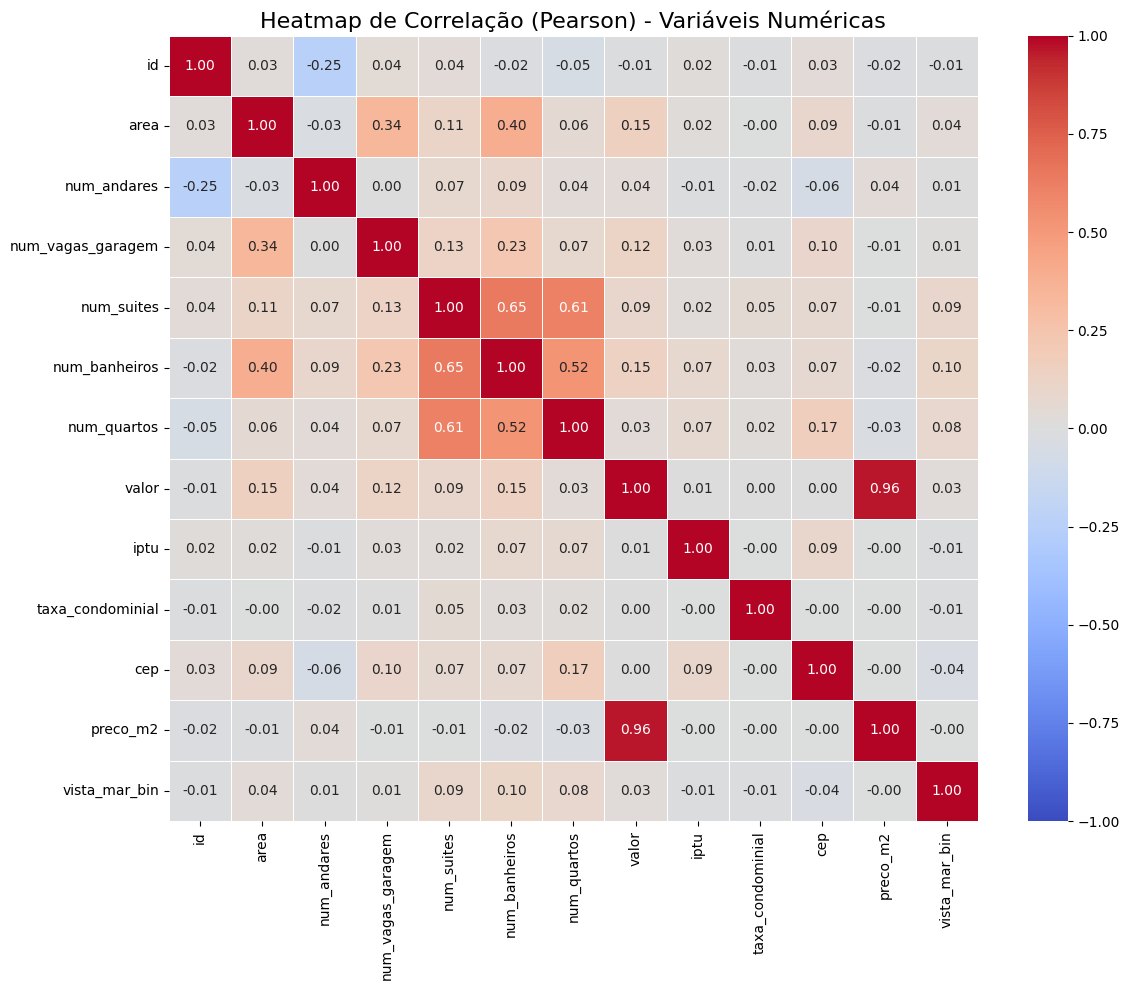

In [4]:
# === PRÉ-REQUISITO: df já carregado ===
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 0) Normalização opcional do nome
if 'vista_Mar' in df.columns and 'vista_mar' not in df.columns:
    df.rename(columns={'vista_Mar': 'vista_mar'}, inplace=True)

# 1) Criar coluna binária 0/1 a partir de 'vista_mar' (se existir e não for numérica)
if 'vista_mar' in df.columns and not pd.api.types.is_numeric_dtype(df['vista_mar']):
    txt = (df['vista_mar']
             .astype(str)
             .str.strip()
             .str.lower())
    map_bool = {
        'true': True, 'false': False,
        '1': True,    '0': False,
        'sim': True,  'nao': False, 'não': False,
        'yes': True,  'no': False,  'y': True, 'n': False
    }
    ser_bool = txt.map(map_bool)
    df['vista_mar_bin'] = ser_bool.map({True: 1, False: 0}).astype('Int64')

elif 'vista_mar' in df.columns and pd.api.types.is_bool_dtype(df['vista_mar']):
    df['vista_mar_bin'] = df['vista_mar'].astype('Int64')

# 2) Selecionar apenas numéricas
df_num = df.select_dtypes(include=[np.number]).copy()

# Garantir presença explícita de 'vista_mar_bin' se existir (e.g., tipo Int64)
if 'vista_mar_bin' in df.columns and 'vista_mar_bin' not in df_num.columns:
    df_num['vista_mar_bin'] = pd.to_numeric(df['vista_mar_bin'], errors='coerce')

# 3) Remover colunas totalmente nulas
df_num = df_num.dropna(axis=1, how='all')

# 4) Remover colunas quase constantes (ex.: 0 variância ou só 1 valor distinto não nulo)
const_cols = [c for c in df_num.columns if df_num[c].nunique(dropna=True) < 2]
if const_cols:
    df_num = df_num.drop(columns=const_cols)

# 5) Matriz de correlação (Pearson)
corr_pear = df_num.corr(method='pearson', min_periods=1)

# 6) Função para listar as top correlações por |valor|
def top_corr(corr: pd.DataFrame, k: int = 10) -> pd.DataFrame:
    c = corr.copy()
    # Ignorar diagonal
    np.fill_diagonal(c.values, np.nan)
    # Ordenar por |correlação| (maior primeiro)
    ordered = c.abs().stack().sort_values(ascending=False)

    pares = []
    vistos = set()
    for (a, b), _ in ordered.items():
        chave = tuple(sorted((a, b)))
        if chave in vistos:
            continue
        vistos.add(chave)
        # valor com sinal original
        pares.append((*chave, corr.loc[a, b]))
        if len(pares) >= k:
            break
    return pd.DataFrame(pares, columns=['var_1', 'var_2', 'corr']).set_index(['var_1', 'var_2'])

print("Top correlações (absolutas) - Pearson:")
display(top_corr(corr_pear, k=12))

# 7) Heatmap (anotar valores apenas se não houver muitas colunas)
annot_flag = df_num.shape[1] <= 16  # evita poluição visual quando há muitas variáveis
plt.figure(figsize=(max(12, 0.7 * df_num.shape[1]), max(10, 0.6 * df_num.shape[1])))
sns.heatmap(corr_pear, vmin=-1, vmax=1, cmap='coolwarm',
            annot=annot_flag, fmt='.2f', linewidths=.5, square=False)
plt.title('Heatmap de Correlação (Pearson) - Variáveis Numéricas', fontsize=16)
plt.tight_layout()
plt.show()


# 4) pair plot (3–5 variáveis importantes)

Colunas no pairplot: ['preco_m2', 'valor', 'area', 'num_vagas_garagem', 'num_quartos'] | hue: vista_mar_label


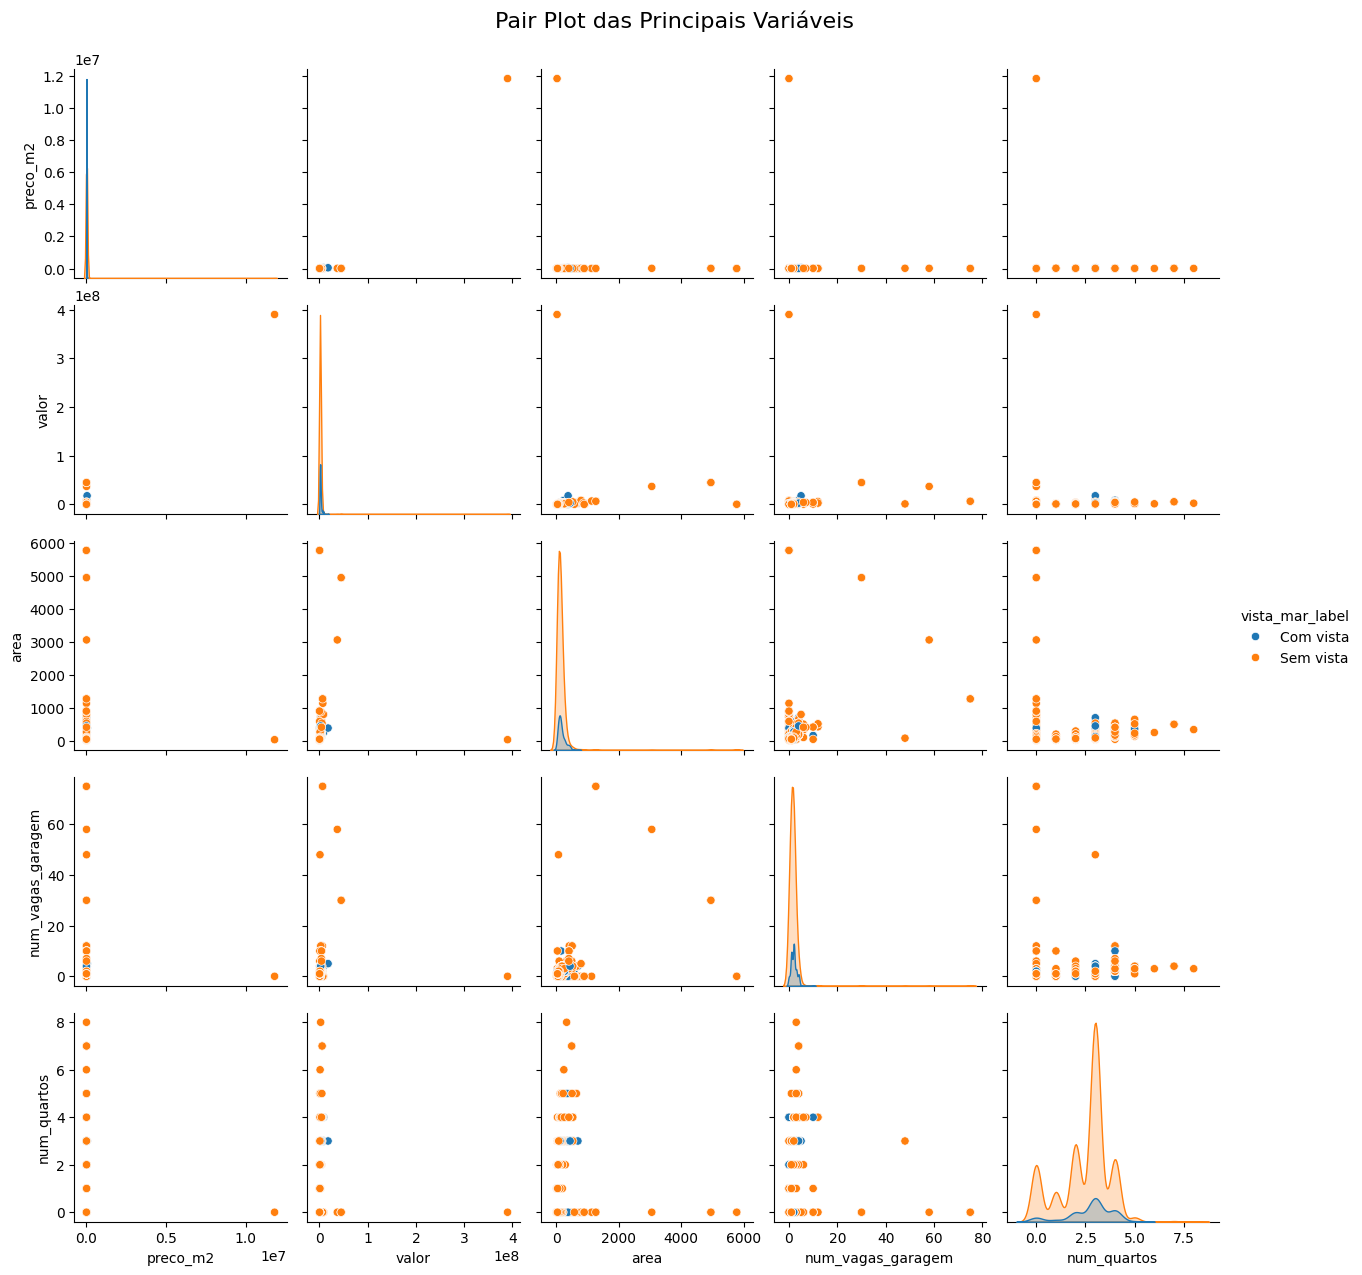

In [5]:
# --- Pair plot (3–5 variáveis importantes) usando vista_mar_bin como hue ---

# 1) escolher variáveis numéricas principais
cands = [c for c in ['preco_m2','valor','area','num_vagas_garagem','num_quartos','num_banheiros'] if c in df.columns]
cols_pair = cands[:5] if len(cands) >= 4 else cands  # até 5 colunas

# 2) preparar HUE priorizando vista_mar_bin
hue = None

# se existir o binário, cria também um rótulo legível p/ legenda
if 'vista_mar_bin' in df.columns:
    if 'vista_mar_label' not in df.columns:
        df['vista_mar_label'] = df['vista_mar_bin'].map({1: 'Com vista', 0: 'Sem vista'}).astype('category')
    hue = 'vista_mar_label'
elif 'vista_mar_bool' in df.columns:
    hue = 'vista_mar_bool'
elif 'vista_mar' in df.columns:
    hue = 'vista_mar'
elif 'tipo_imovel' in df.columns:
    hue = 'tipo_imovel'  # fallback se nada de vista existir

print("Colunas no pairplot:", cols_pair, "| hue:", hue)

# 3) base limpa (amostra opcional para aliviar renderização)
BASE = df.dropna(subset=cols_pair).copy()
if len(BASE) > 3000:
    BASE = BASE.sample(3000, random_state=42)

# 4) pair plot
sns.pairplot(BASE[cols_pair + ([hue] if hue else [])], hue=hue, diag_kind='kde')
plt.suptitle('Pair Plot das Principais Variáveis', y=1.02, fontsize=16)
plt.show()


## Análise do Pair Plot (3–5 variáveis)

### Padrões observados:

area × valor apresenta tendência ascendente (como esperado), mas com grande dispersão em valores altos (heterocedasticidade) e cauda longa — típico de mercado imobiliário.

Com hue = vista_mar, não há separação nítida no agregado — coerente com o heatmap: o efeito de “vista” parece não homogêneo e possivelmente concentrado em segmentos (ex.: metragens médias, andares altos, eixos mais próximos da Beira-Mar).

### Confirma/contradiz hipóteses da Aula 04?

Confirma a relação positiva entre metragem e preço total (mesmo que Pearson global tenha sido baixo).
Não confirma visualmente um prêmio geral de preco_m2 para “vista” sem controle — reforça a necessidade de estratificação e controle locacional.

###  Surpresas / ausências:

A ausência de separação entre “Com vista” vs. “Sem vista” no par preco_m2 pode ser efeito de amostra pequena, detecção textual incompleta ou mistura de submercados (prédios antigos vs. novos).

### Como isso aproxima a resposta de negócio?

Os gráficos mostram que área e o programa interno (quartos/banheiros/suítes) caminham juntos, e que vagas e área devem entrar no modelo de preço. Já a vista para o mar não aparece no agregado, sinalizando que seu prêmio depende do segmento (ex.: faixa de área/andar/localização) e precisa ser medido controlando por essas variáveis. Assim, vamos modelar preco_m2 como função de área, vagas, vista e proximidade à Beira-Mar (distância calculada via lat/lon), testando interações (ex.: vista × faixa de área). Os coeficientes desse modelo darão justamente o peso relativo de cada fator (ex.: % de prêmio da vista, R$/m² por 100 m mais perto da Beira-Mar, efeito de +1 vaga e de +10 m²).
